# Pythonic BERT

## Pythonic?

Last week we held a great class here at #nuwcnpt for "Introduction to Python".   One of the things we emphasized was while python is "just another language", there are certain tasks that can be accomplished more efficiently by leveraging python lists.  The pattern is called "list comprehension" and it allows you to turn this:

    # keep words longer than 5 char and make them upper case
    x = []
    for i in range(len(items)):
        a = items[i]
        if(len(a)>5):
            a = a.upper()
            x = x + a

into this:

    x = [ item.upper() for item in items if(len(item) > 5 ] 
    
When we leverage python syntax, we refer to that as being *"Pythonic"*

## BERT

BERT is a state of the art language model from Google.  One of its main functions is to convert sentences into numerical vectors.  Similar sentences will have similar vectors.  

We will use these vectors to show that collections of similar sentences will form groups, and we will try to do this with cleaner, more *pythonic* code!

BERT is very powerful and easy to use once you get the hang of it.  The encoding service is widely available on the RDTE/NREN network at the NUWCNPT ASECC and can be accessed remotely. 

This code and data has been published at [https://www.github.com/simusid/ML_examples](https://www.github.com/simusid/ML_examples)

Please feel free to contact me at [gary.huntress@navy.mil](mailto:gary.huntress@navy.mil) with any feedback or questions.   


# Libraries

First, load the libraries we'll need.  Then connect to the remote BERT server.  

In [1]:
 
from bert_serving.client import BertClient
import matplotlib.pyplot as plt
from umap import UMAP
import numpy as np

bc = BertClient(ip='10.0.1.203')
 

## Data

I've created four small datasets of 100 simple sentences per topic.  Examples are:

* **SPACE** - The Whirlpool Galaxy (M51) was the first celestial object identified as being spiral.
* **DOGS** - A dog’s shoulder blades are unattached to the rest of the skeleton to allow greater flexibility for running.
* **QUOTES** - “Few things can help an individual more than to place responsibility on him, and to let him know that you trust him.” – Booker T. Washington
* **CATS** - Approximately 40,000 people are bitten by cats in the U.S. annually.

We have to load each file, clean up each sentence and return 4 sets of strings.  The getText() function does this with one use of "list comprehension".  Then this function is called four times, once for each file, in the last statement.  The data variable hold four lists of sentences.


In [2]:
fnames =['dog_facts.txt','space_facts.txt','inspirational_quotes.txt','cat_facts.txt']

DOGS =0
SPACE =1
QUOTES =2
CATS =3

def getText(fname):
    with open(fname) as fh: 
        data = [d.replace("\n"," ").lower() for d in fh.readlines() if(len(d)>10) ]    
    return data

data = [getText(f) for f in fnames]


## BERT Encoding

Data holds four lists of sentences.  We could pass everything to BERT and get back all the encodings, but if we did that then the groups would no longer be distnct.  List comprehension to the rescue again.  We take each item in data and build a new list with the returned encoded values.  

The vectors variable is a list with four members, a set of vectors for each group of sentences.

In [3]:
vectors = [bc.encode(d) for d in data]

/home/gary/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=25" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


## Visualization 

The premise is that if I encode two similar sentences, I will get two vectors that point roughly in the same direction.  The "CAT" vectors should generally be pointing in the same direction and so should "DOGS".  But mutually they should be distinct.  

Unfortunately, the vectors are very high dimension. So the first step is to use a tool to help us visualize the vectors in only two dimensions.  A good tool for this is [UMAP](https://umap-learn.readthedocs.io/en/latest/) 

Below, we create a transform object and then call it pythonically four times, once for each set of vectors.  The *groups* variable now holds four sets of 2 dimensional points that we can plot.  The next line plots each of these four groups as a scatter plot.  A final list comprehension is used to assign a text lable to each group.  Note that we use a different type of enumeration here to get both the index, and the value.



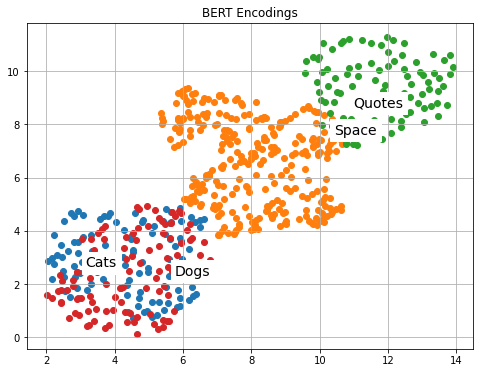

In [23]:
plt.figure(figsize=(8,6))
plt.grid()
transform = UMAP( random_state=16
                )
groups = [ transform.fit_transform(v) for v in vectors ]

# make a scatter plot for each group
[ plt.scatter(group[:,0], group[:,1]) for group in groups ]
plt.title("BERT Encodings") 

labels= ['Dogs','Space','Quotes', 'Cats']

[plt.text(group[0,0],group[0,1],labels[i],fontsize=14, backgroundcolor='white' 
          ) for i, group in enumerate( groups)];


# Groups

We plotted each individual group above separately.  That is, we already knew the group membership (and color).   Is it possible to look at a 2D collection of points and assign a group membership?   Yes, certainly and there are many tools to do so. Today I'm using [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/index.html) which belongs to the family of "Density based clustering" tools.

First, we load the library and create the clustering object.  Then instead of having four separate groups of vectors, we stack them all into a single tall array.  Remember, these vectors are now "reduced" in that they have been mapped from a high D space to a 2D space.

The vectors are passed through the clusterer.fit() function.  Once that is done, each data point has a cluster number assigned to it in the variable clusters.labels_.  We then replot allvectors with those colors to indicate the groups.


Text(0.5, 1.0, 'Clusters Labeled With HDBSCAN')

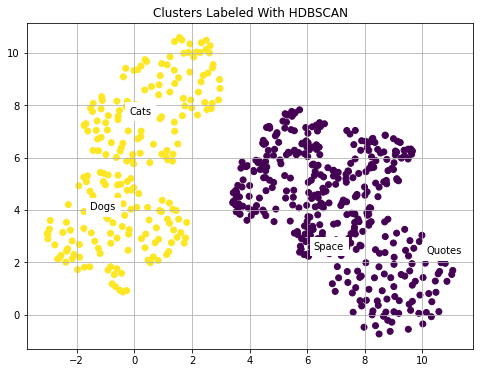

In [19]:
 
import hdbscan
clusterer = hdbscan.HDBSCAN() 

allvectors =np.vstack([f for f in np.array(groups)])
 
clusters = clusterer.fit(allvectors)
plt.figure(figsize=(8,6))
plt.grid()
plt.scatter(allvectors[:,0],allvectors[:,1], c=clusters.labels_)
[plt.text(group[0,0],group[0,1],labels[i], backgroundcolor='white' 
          ) for i, group in enumerate( groups)];
plt.title("Clusters Labeled With HDBSCAN")

## Group Assignment and New Data

The graph above shows that we can convert text to vectors and then form identifiable groups.  But what if we get new text?  Can we determine which group it belongs in?  Again, there are many ways to do this.

<table width='100%'>
    <tr>
        <td>Let's try one of my favorite Ralph Wiggum quotes!</td>
<td>
<img style='width:80px' src='https://tv-fanatic-res.cloudinary.com/iu/s--9XpWZdiq--/t_full/cs_srgb,f_auto,fl_strip_profile.lossy,q_auto:420/v1371135394/ralph-wiggum-pic.png'/>
        </td>
    </tr>
    </table>

First we encode the sentence as a high dimension vector.  Remember from above, we created a transform object to map data into the 2D space.  We re-use that mapping to put the new point in the same space. 

In [ ]:
ralph_wiggum = bc.encode(["my cats breath smells like cat food"])
rw_vector=transform.transform(ralph_wiggum)
rw_vector

And then re-plot the point, noting it correctly shows up in the "CATS" cluster.

In [ ]:
plt.figure(figsize=(8,6))
plt.grid()
plt.scatter(allvectors[:,0],allvectors[:,1], c=clusters.labels_);
plt.plot(rw_vector[:,0],rw_vector[:,1], c='r', marker='X');
plt.title("My Cats Breath Smells Like Cat Food")

points ={1:0,2:0,3:0,0:0}
labels=["QUOTES", "DOGS", "CATS", "SPACE"]
for p in zip(allvectors, clusters.labels_):
    points[p[1]]=p[0];

#[plt.text(points[i][0], points[i][1], labels[i], color='black', backgroundcolor="white") for  i in range(4)];
